# Financial Returns Analysis with Python: From Prices to Risk Metrics

## Abstract

This tutorial provides a foundation for analyzing financial returns using Python. You'll learn to compute returns from price data, understand risk metrics, and build a comprehensive performance analysis framework. The notebook is designed for two audiences: finance students seeking practical coding skills, and programmers/data scientists wanting essential finance concepts.

## TL;DR

- Convert prices to returns using `pct_change()` (recommended) or manual calculations
- Compound returns properly: `(1 + returns).prod() - 1` 
- Annualize metrics using frequency factors (252 for daily, 12 for monthly)
- Measure risk with volatility, Sharpe ratio, and maximum drawdown
- Compare assets using a standardized metrics table

## Table of Contents

1. **From Prices to Returns**
   - Simple vs Log Returns  
   - Three Calculation Methods
   - Handling Missing Values
2. **Compounding and Annualizing**
   - Total Return Calculation
   - Annualization Framework
3. **Risk Analysis**
   - Descriptive Statistics
   - Rolling Metrics
   - Sharpe Ratio
4. **Drawdown Analysis**
   - Wealth Evolution
   - Maximum Drawdown
5. **Performance Summary Table**
6. **Conclusion - Key Insights**
7. **Using Your Own Data**
8. **References**

In [553]:
# Setup: 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

np.random.seed(42)

plt.style.use('default')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 11
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.3

print("Libraries imported and plotting configured successfully.")

Libraries imported and plotting configured successfully.


## 1. From Prices to Returns

### What is a return ? 
Returns measure the percentage change in asset value over time. They are the foundation for all performance and risk analysis in finance.

### Simple vs Log Returns

**Simple Returns:** $$R_t = \frac{P_t - P_{t-1}}{P_{t-1}} = \frac{P_t}{P_{t-1}} - 1$$

**Log Returns:** $$r_t = \ln(P_t) - \ln(P_{t-1}) = \ln\left(\frac{P_t}{P_{t-1}}\right)$$

**When to use each:**
- **Simple returns**: Intuitive interpretation ("stock gained 5%"), used for portfolio aggregation
- **Log returns**: Time-additive property ($r_{total} = r_1 + r_2 + ... + r_n$), better for modeling
- **Small-return approximation**: For returns < 10%, $r_t \approx R_t$

**In practice**: Use simple returns for most financial analysis, log returns for econometric modeling.

### Example: Computing Returns from Price Series

Consider a stock with the following daily prices:
- Thursday: $8.70
- Friday: $8.91  
- Saturday: $8.71

In [554]:
# Sample price data
prices_example = np.array([8.70, 8.91, 8.71])
print("Sample prices:", prices_example)

Sample prices: [8.7  8.91 8.71]


Let's calculate returns using multiple methods to understand the mechanics.

#### Manual Calculation

Let's manually calculate the return from Thursday to Friday:

In [555]:
# Manual calculation: Thursday to Friday return
return_manual = 8.91 / 8.70 - 1

print(f"Return from Thursday to Friday: {return_manual:.4f} or {return_manual*100:.2f}%")

Return from Thursday to Friday: 0.0241 or 2.41%


#### Method 1: NumPy Array Slicing

For a complete price series, you can compute all returns at once using NumPy:

In [556]:
# Method 1: NumPy array slicing
returns_numpy = prices_example[1:] / prices_example[:-1] - 1
print("Returns using NumPy:", returns_numpy)
print("Returns in percentages:", (returns_numpy * 100).round(2), "%")

Returns using NumPy: [ 0.02413793 -0.02244669]
Returns in percentages: [ 2.41 -2.24] %


Perfect! We get the first return of 2.41% (Thursday to Friday) and the second return of -2.25% (Friday to Saturday).

#### Now let's analyze the returns of several assets : Stock A and Stock B 

In [557]:
# Create a multi-asset price DataFrame
prices_multi = pd.DataFrame({
    "STOCK_A": [8.70, 8.91, 8.71, 8.43, 8.73],
    "STOCK_B": [10.66, 11.08, 10.71, 11.59, 12.11]
})

print("Multi-asset price data:")
print(prices_multi)

Multi-asset price data:
   STOCK_A  STOCK_B
0     8.70    10.66
1     8.91    11.08
2     8.71    10.71
3     8.43    11.59
4     8.73    12.11


### Method 2: Using pandas.shift()

When working with pandas DataFrames, index alignment matters. The naive approach fails because pandas aligns on row indices:

In [558]:
# This DOESN'T work as expected due to index alignment
try:
    naive_attempt = prices_multi.iloc[1:] / prices_multi.iloc[:-1] - 1
    print("Naive approach (WRONG):")
    print(naive_attempt)
except Exception as e:
    print(f"Error: {e}")

Naive approach (WRONG):
   STOCK_A  STOCK_B
0      NaN      NaN
1      0.0      0.0
2      0.0      0.0
3      0.0      0.0
4      NaN      NaN


The issue occurs because pandas aligns indices (0,1,2,3,4) with (1,2,3,4), creating mismatched rows. Use `.shift(1)` to properly align previous period prices:

In [559]:
# Using shift(1) to align previous prices
print("Original prices:")
print(prices_multi)
print("\nPrices shifted by 1 period:")
print(prices_multi.shift(1))

Original prices:
   STOCK_A  STOCK_B
0     8.70    10.66
1     8.91    11.08
2     8.71    10.71
3     8.43    11.59
4     8.73    12.11

Prices shifted by 1 period:
   STOCK_A  STOCK_B
0      NaN      NaN
1     8.70    10.66
2     8.91    11.08
3     8.71    10.71
4     8.43    11.59


Now we can calculate returns correctly:

In [560]:
# Method 2: Using shift() for proper alignment
returns_shift = prices_multi / prices_multi.shift(1) - 1
print("Returns using shift():")
print(returns_shift.round(4))

Returns using shift():
   STOCK_A  STOCK_B
0      NaN      NaN
1   0.0241   0.0394
2  -0.0224  -0.0334
3  -0.0321   0.0822
4   0.0356   0.0449


### Method 3: pct_change() - Recommended Approach

pandas `.pct_change()` handles all complexity automatically and is the industry standard [[1]](#references):

In [561]:
# Method 3: pct_change() - RECOMMENDED
returns_pct = prices_multi.pct_change()
print("Returns using pct_change():")
print(returns_pct.round(4))

# Handle the first-row NaN
print(f"\nFirst row contains NaN because there's no previous price to compare:")
print(f"Shape before: {returns_pct.shape}")
returns_clean = returns_pct.dropna()
print(f"Shape after dropna(): {returns_clean.shape}")
print("\nClean returns:")
print(returns_clean.round(4))

Returns using pct_change():
   STOCK_A  STOCK_B
0      NaN      NaN
1   0.0241   0.0394
2  -0.0224  -0.0334
3  -0.0321   0.0822
4   0.0356   0.0449

First row contains NaN because there's no previous price to compare:
Shape before: (5, 2)
Shape after dropna(): (4, 2)

Clean returns:
   STOCK_A  STOCK_B
1   0.0241   0.0394
2  -0.0224  -0.0334
3  -0.0321   0.0822
4   0.0356   0.0449


### Working with Real Market Data

Let's load actual price data from a CSV file and calculate returns for a more realistic analysis:

In [562]:
# Load price data from CSV
prices = pd.read_csv('Data/sample_prices.csv')
print("Market price data:")
print(prices.head())

Market price data:
     BLUE   ORANGE
0  8.7000  10.6600
1  8.9055  11.0828
2  8.7113  10.7100
3  8.4346  11.5907
4  8.7254  12.1070


In [563]:
# Calculate returns from the market data
returns = prices.pct_change().dropna()
print("Market returns:")
print(returns.head())
print(f"\nReturns summary:")
print(returns.describe().round(4))

Market returns:
       BLUE    ORANGE
1  0.023621  0.039662
2 -0.021807 -0.033638
3 -0.031763  0.082232
4  0.034477  0.044544
5  0.037786 -0.026381

Returns summary:
          BLUE   ORANGE
count  12.0000  12.0000
mean    0.0100   0.0100
std     0.0240   0.0796
min    -0.0318  -0.1683
25%    -0.0117  -0.0375
50%     0.0167   0.0319
75%     0.0304   0.0701
max     0.0378   0.1170


### Initial Visualization

Let's create some basic visualizations to understand our data:

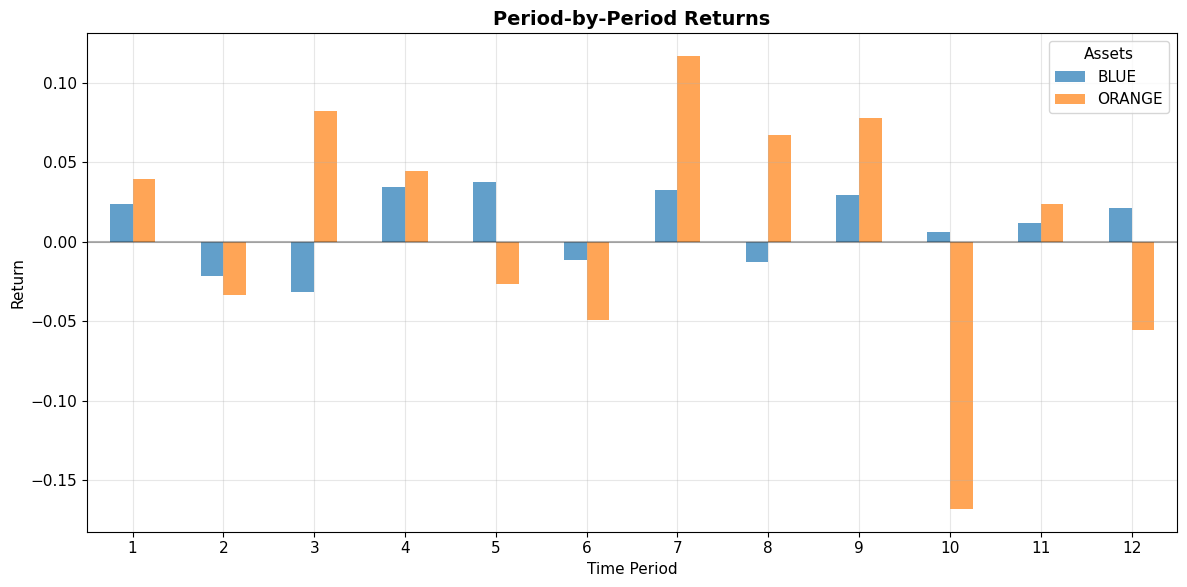

Observation: The bar chart shows the volatility of returns across periods
Notice how both assets experience both positive and negative returns.


In [564]:
# Bar chart of period-by-period returns
fig, ax = plt.subplots(figsize=(12, 6))
returns.plot(kind='bar', ax=ax, alpha=0.7)
ax.set_title('Period-by-Period Returns', fontsize=14, fontweight='bold')
ax.set_xlabel('Time Period')
ax.set_ylabel('Return')
ax.legend(title='Assets')
ax.axhline(y=0, color='black', linestyle='-', alpha=0.3)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

print("Observation: The bar chart shows the volatility of returns across periods\n"
      "Notice how both assets experience both positive and negative returns."
      )

In [565]:
# Calculate and display mean returns
mean_returns = returns.mean()
print("Mean returns by asset:")
for asset, mean_ret in mean_returns.items():
    print(f"{asset}: {mean_ret:.4f} ({mean_ret*100:.2f}%)")
    
print(f"\nInterpretation: These are the average returns per period\n"
"Higher mean returns suggest better average performance, but don't account for risk."
)

Mean returns by asset:
BLUE: 0.0100 (1.00%)
ORANGE: 0.0100 (1.00%)

Interpretation: These are the average returns per period
Higher mean returns suggest better average performance, but don't account for risk.


We notice that the average is the same, yet instinctively we can see that the two returns do not behave in the same way. The return of the orange asset is much more volatile than the blue one.

In [566]:
# Calculate and display return volatility (standard deviation)
std_returns = returns.std()
print("Return volatility (standard deviation) by asset:")
for asset, std_ret in std_returns.items():
    print(f"{asset}: {std_ret:.4f} ({std_ret*100:.2f}%)")

print(f"\nInterpretation: Standard deviation measures the typical fluctuation around the mean.")
print(f"Higher volatility indicates more unpredictable returns and higher risk.")

Return volatility (standard deviation) by asset:
BLUE: 0.0240 (2.40%)
ORANGE: 0.0796 (7.96%)

Interpretation: Standard deviation measures the typical fluctuation around the mean.
Higher volatility indicates more unpredictable returns and higher risk.


The calculation of the standard deviation confirms what we observed instinctively from the chart.

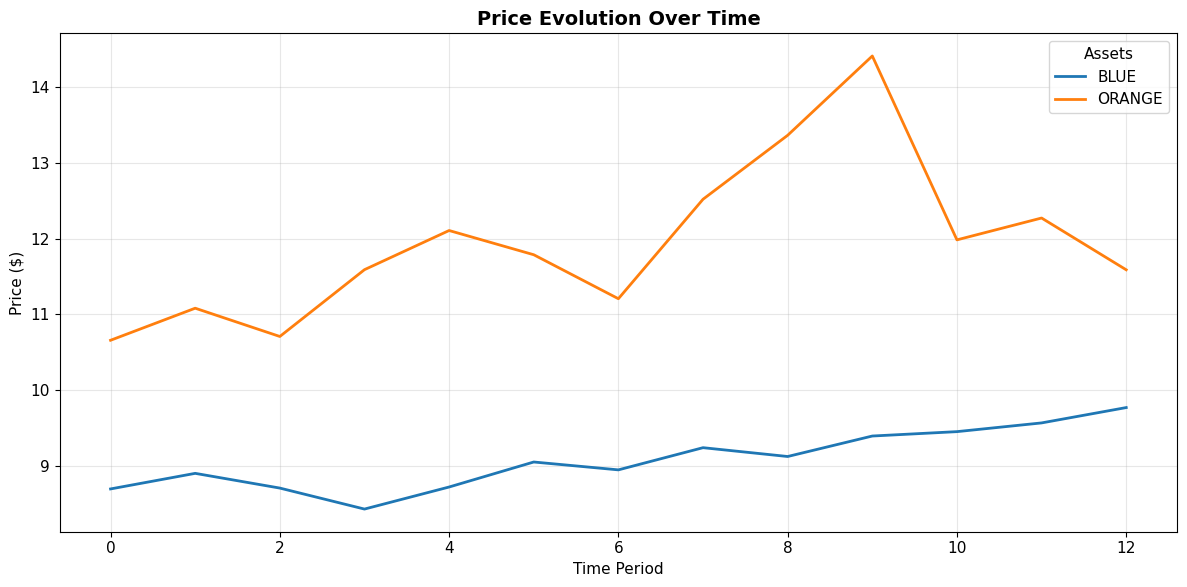

Observation: The price chart shows the cumulative effect of returns.
While both assets start at different price levels, we can see their relative growth paths.


In [567]:
# Line chart of price evolution
fig, ax = plt.subplots(figsize=(12, 6))
prices.plot(ax=ax, linewidth=2)
ax.set_title('Price Evolution Over Time', fontsize=14, fontweight='bold')
ax.set_xlabel('Time Period')
ax.set_ylabel('Price ($)')
ax.legend(title='Assets')
plt.tight_layout()
plt.show()

print("Observation: The price chart shows the cumulative effect of returns.\n"
    "While both assets start at different price levels, we can see their relative growth paths."
    )

## 2. Compounding and Annualizing Returns

Compounding captures how returns build upon each other over time. Annualization standardizes metrics for comparison across different time periods.

### Total Compounded Return

To find the total return over multiple periods, we convert returns to "gross returns" (1 + return), multiply them together, then subtract 1. This accounts for the compounding effect where gains/losses build upon previous gains/losses.

In [568]:
# Convert returns to gross returns (1 + return) 
gross_returns = returns + 1
print("Gross returns (1 + return):")
print(gross_returns.head().round(4))

Gross returns (1 + return):
     BLUE  ORANGE
1  1.0236  1.0397
2  0.9782  0.9664
3  0.9682  1.0822
4  1.0345  1.0445
5  1.0378  0.9736


In [569]:
# Total compounded return calculation (no deprecation warnings)
total_returns = gross_returns.prod(axis=0) - 1

print("Total Compounded Returns:")
print("=" * 40)
for asset, total_ret in total_returns.items():
    print(f"{asset}: {total_ret:.4f} ({total_ret*100:.2f}%)")

print(f"\nInterpretation: Total return from holding each asset for the entire period.")
print(f"This accounts for the compounding effect where gains/losses build upon each other.")

Total Compounded Returns:
BLUE: 0.1233 (12.33%)
ORANGE: 0.0872 (8.72%)

Interpretation: Total return from holding each asset for the entire period.
This accounts for the compounding effect where gains/losses build upon each other.


It means that if you had held each asset from start to finish, BLUE would have grown by 12.33% while ORANGE would have grown by 8.72%, taking into account the compounding effect where each gain or loss builds on the previous one.

### Annualization Framework
A daily or monthly return doesn’t make much sense if it isn’t scaled to an annual level, since investment horizons are usually expressed in years.
By annualizing, we can easily compare an asset A that yields 1% per month with an asset B that yields 0.05% per day.
The same applies to volatility: annualizing allows us to understand the total expected risk over one year and to compare assets or portfolios that don’t have the same data frequency.

Convert any frequency to annual metrics using these formulas:

$$\text{Annualized Return} = (1 + R_{avg})^{periods\_per\_year} - 1$$
$$\text{Annualized Volatility} = \sigma \times \sqrt{periods\_per\_year}$$

**Standard frequencies:**
- Daily: `periods_per_year = 252` (trading days)
- Monthly: `periods_per_year = 12` 
- Quarterly: `periods_per_year = 4`

In [570]:
# Example: Annualizing a 2% monthly return
rm = 0.02
annual_from_monthly = (1 + rm)**12 - 1
print(f"2% monthly return annualized: {annual_from_monthly:.4f} ({annual_from_monthly*100:.2f}%)")

2% monthly return annualized: 0.2682 (26.82%)


In [571]:
# Example: Annualizing a 10% quarterly return  
rq = 0.1
annual_from_quarterly = (1 + rq)**4 - 1
print(f"10% quarterly return annualized: {annual_from_quarterly:.4f} ({annual_from_quarterly*100:.2f}%)")

10% quarterly return annualized: 0.4641 (46.41%)


Example 2 :

To annualize a 1% monthly, and 4% quarterly and a 0.01% daily return you would do:

In [572]:
# Annualization examples with clear frequency parameter
periods_per_year = 252  # Adjust based on your data frequency

print("Annualization Examples:")
print("=" * 30)

# Daily return example
rd = 0.001
annual_from_daily = (1 + rd)**periods_per_year - 1
print(f"0.1% daily return → {annual_from_daily:.1%} annualized")

# Monthly return example  
rm = 0.01
annual_from_monthly = (1 + rm)**12 - 1
print(f"1.0% monthly return → {annual_from_monthly:.1%} annualized")

# Quarterly return example
rq = 0.04
annual_from_quarterly = (1 + rq)**4 - 1
print(f"4.0% quarterly return → {annual_from_quarterly:.1%} annualized")

print(f"\nKey insight: Consistent small returns compound to substantial annual gains.")

Annualization Examples:
0.1% daily return → 28.6% annualized
1.0% monthly return → 12.7% annualized
4.0% quarterly return → 17.0% annualized

Key insight: Consistent small returns compound to substantial annual gains.


This example perfectly illustrates the power of compound returns and why it is often more important to achieve small, consistent gains rather than aim for occasional big wins.

- A daily return of just 0.1% grows into 28.6% per year, which is significantly higher than the monthly or quarterly returns shown.
- Yet, 0.1% may seem insignificant on a day-to-day basis — it’s the frequency and continuous compounding of these gains that create a snowball effect.

## 3. Risk Analysis

Risk analysis examines return variability, extreme outcomes, and risk-adjusted performance. We'll compute standard risk metrics and visualize return distributions.

### Descriptive Statistics

The `describe()` method provides a comprehensive statistical summary of our return distributions:

In [573]:
# Comprehensive statistical summary
print("Return Distribution Summary:")
print("=" * 50)
desc_stats = returns.describe()
print(desc_stats.round(4))

print("\nKey insights:")
print(f"• Mean returns show average performance per period")
print(f"• Standard deviation indicates volatility/risk") 
print(f"• Min/Max show the range of outcomes experienced")
print(f"• Quartiles (25%, 50%, 75%) show distribution shape")

Return Distribution Summary:
          BLUE   ORANGE
count  12.0000  12.0000
mean    0.0100   0.0100
std     0.0240   0.0796
min    -0.0318  -0.1683
25%    -0.0117  -0.0375
50%     0.0167   0.0319
75%     0.0304   0.0701
max     0.0378   0.1170

Key insights:
• Mean returns show average performance per period
• Standard deviation indicates volatility/risk
• Min/Max show the range of outcomes experienced
• Quartiles (25%, 50%, 75%) show distribution shape


Even though the average returns are identical, BLUE offers more stable and predictable performance, making it a safer choice for conservative investors.
On the other hand, ORANGE carries a higher level of risk (greater volatility and larger potential losses) but also offers a higher potential for gains.

### Return Distribution Histograms

Visualizing the distribution of returns helps identify characteristics like skewness and kurtosis:

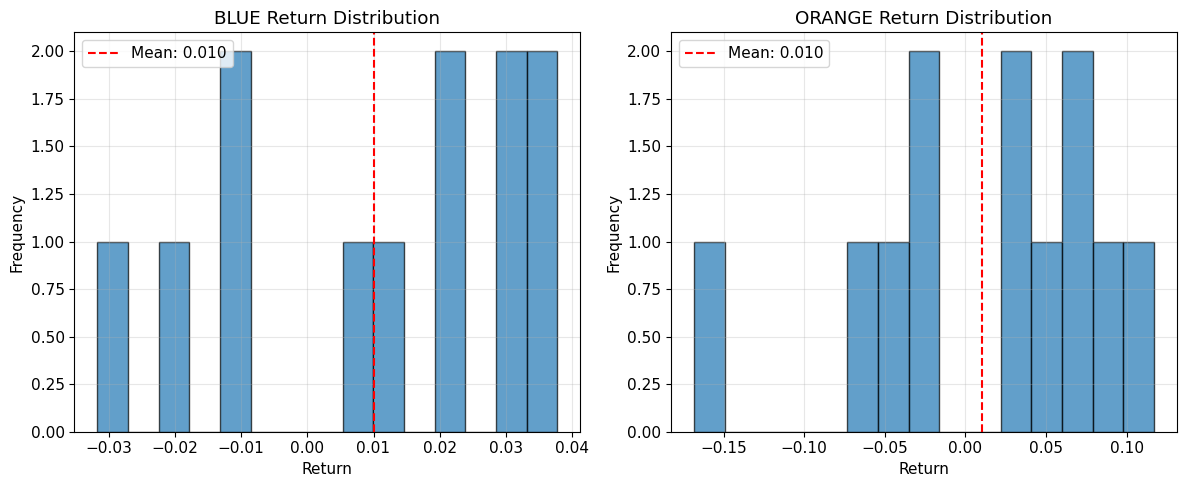

Observation: The histograms reveal the distribution shape of returns.
Look for symmetry, outliers, and whether the distribution appears normal.
Financial returns often exhibit 'fat tails' (more extreme values than normal distribution).


In [574]:
# Create histograms for each asset
fig, axes = plt.subplots(1, len(returns.columns), figsize=(12, 5))
if len(returns.columns) == 1:
    axes = [axes]

for i, column in enumerate(returns.columns):
    axes[i].hist(returns[column], bins=15, alpha=0.7, edgecolor='black')
    axes[i].set_title(f'{column} Return Distribution')
    axes[i].set_xlabel('Return')
    axes[i].set_ylabel('Frequency')
    axes[i].axvline(returns[column].mean(), color='red', linestyle='--', 
                    label=f'Mean: {returns[column].mean():.3f}')
    axes[i].legend()

plt.tight_layout()
plt.show()

print("Observation: The histograms reveal the distribution shape of returns.")
print("Look for symmetry, outliers, and whether the distribution appears normal.")
print("Financial returns often exhibit 'fat tails' (more extreme values than normal distribution).")

##### BLUE Asset – More Concentrated Distribution
The bars are closer to each other and more centered around the mean.
This means that most returns are near the average, with few extreme deviations.
BLUE therefore shows low volatility and a more stable and predictable distribution.

##### ORANGE Asset – Wider Distribution and More Frequent Extremes
The bars are spread over a much wider range of returns.
We observe extreme values (up to around -0.15 and 0.10), indicating higher volatility.
The distribution also exhibits “fat tails,” which is typical of financial data, meaning that extreme events (large losses or gains) are more likely than in a normal distribution.

### Rolling Statistics

Rolling statistics help identify how volatility and performance change over time:

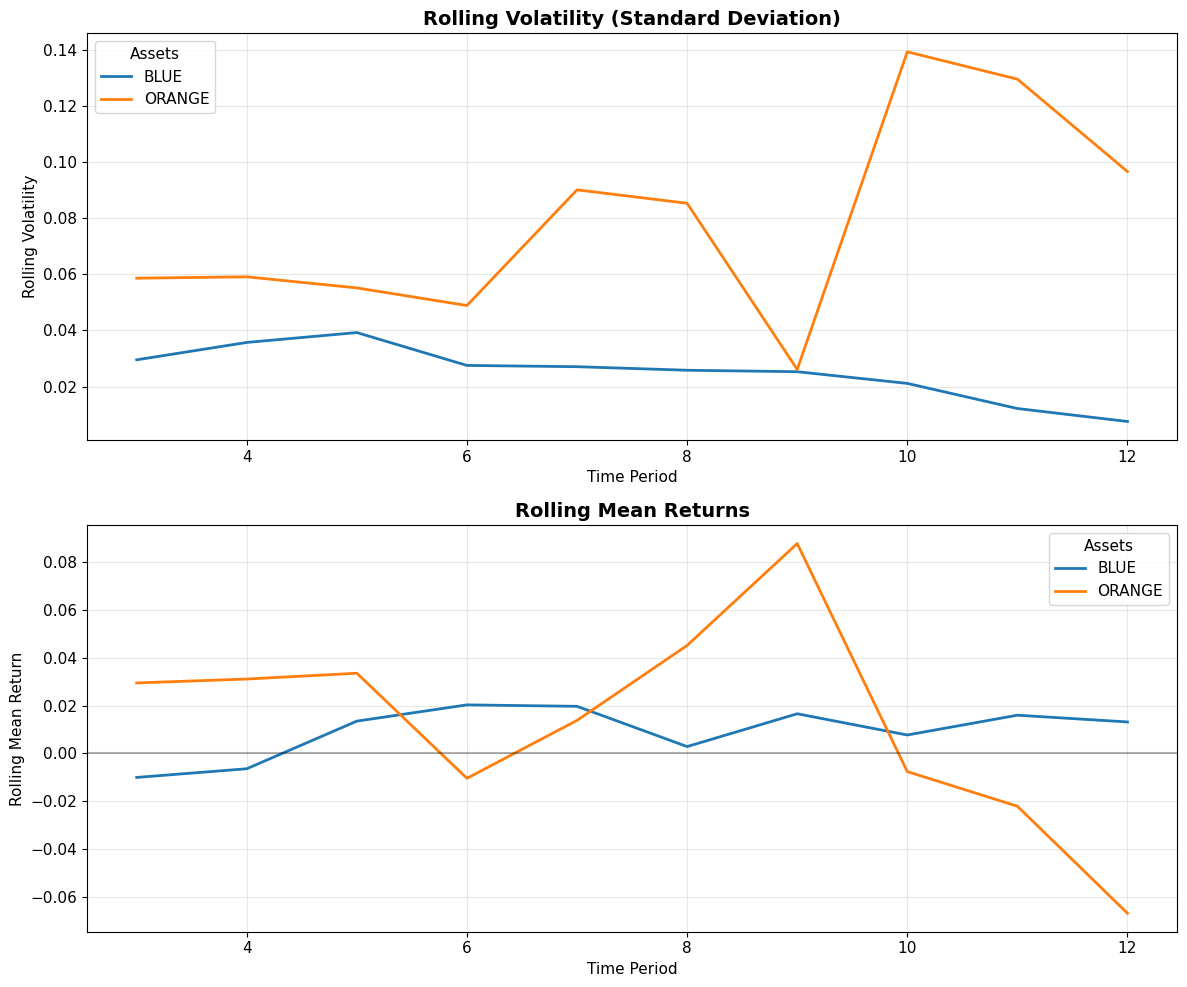

Observations:
• Rolling volatility shows how risk varies over time
• Periods of high volatility often cluster together (volatility clustering)
• Rolling mean returns show performance trends over time


In [575]:
# Calculate rolling statistics (using a 3-period window for our small dataset)
window = min(3, len(returns))  # Adjust window size for small datasets
rolling_vol = returns.rolling(window=window).std()
rolling_mean = returns.rolling(window=window).mean()

# Plot rolling volatility
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# Rolling volatility
rolling_vol.plot(ax=ax1, linewidth=2)
ax1.set_title('Rolling Volatility (Standard Deviation)', fontsize=14, fontweight='bold')
ax1.set_xlabel('Time Period')
ax1.set_ylabel('Rolling Volatility')
ax1.legend(title='Assets')

# Rolling mean returns
rolling_mean.plot(ax=ax2, linewidth=2)
ax2.set_title('Rolling Mean Returns', fontsize=14, fontweight='bold')
ax2.set_xlabel('Time Period')
ax2.set_ylabel('Rolling Mean Return')
ax2.legend(title='Assets')
ax2.axhline(y=0, color='black', linestyle='-', alpha=0.3)

plt.tight_layout()
plt.show()

print("Observations:")
print("• Rolling volatility shows how risk varies over time")
print("• Periods of high volatility often cluster together (volatility clustering)")
print("• Rolling mean returns show performance trends over time")

### Sharpe Ratio Analysis

The Sharpe ratio measures risk-adjusted performance by comparing excess return to volatility [[Sharpe]](https://web.stanford.edu/~wfsharpe/art/sr/sr.htm). It's calculated as:

$$\text{Sharpe Ratio} = \frac{R_p - R_f}{\sigma_p}$$

Where $R_p$ is the portfolio return, $R_f$ is the risk-free rate, and $\sigma_p$ is the portfolio volatility.

In [576]:
# Sharpe Ratio Analysis
rf = 0.0  # Risk-free rate (start with 0 for tutorial)
periods_per_year = 12  # Adjust based on your data frequency

# Period and annualized Sharpe ratios
sharpe_period = (returns.mean() - rf) / returns.std()
sharpe_annual = sharpe_period * np.sqrt(periods_per_year)

print("Sharpe Ratio Analysis:")
print("=" * 40)
print("Period Sharpe Ratios:")
for asset, sharpe in sharpe_period.items():
    print(f"  {asset}: {sharpe:.3f}")

print(f"\nAnnualized Sharpe Ratios:")
for asset, sharpe in sharpe_annual.items():
    print(f"  {asset}: {sharpe:.3f}")

print(f"\nInterpretation:")
print(f"• Higher Sharpe = better risk-adjusted performance")
print(f"• Sharpe > 1.0 considered good, > 2.0 excellent")
print(f"• Limitation: assumes normal return distribution")

Sharpe Ratio Analysis:
Period Sharpe Ratios:
  BLUE: 0.417
  ORANGE: 0.126

Annualized Sharpe Ratios:
  BLUE: 1.445
  ORANGE: 0.435

Interpretation:
• Higher Sharpe = better risk-adjusted performance
• Sharpe > 1.0 considered good, > 2.0 excellent
• Limitation: assumes normal return distribution


## 4. Drawdown Analysis

Drawdowns measure peak-to-trough declines in portfolio value. Maximum drawdown is a critical risk metric showing the worst-case loss an investor experienced.

In [577]:
# Calculate wealth evolution and drawdowns
wealth = (1 + returns).cumprod()  # Cumulative wealth starting from $1
rolling_peak = wealth.expanding().max()  # Rolling maximum (peak values)
drawdown = (wealth - rolling_peak) / rolling_peak  # Drawdown as percentage

# Maximum drawdown for each asset
max_drawdown = drawdown.min()

print("Maximum Drawdown Analysis:")
print("=" * 40)
for asset, max_dd in max_drawdown.items():
    print(f"{asset}: {max_dd:.1%}")

print(f"\nInterpretation:")
print(f"• Max drawdown shows worst peak-to-trough decline")
print(f"• Lower (more negative) = more painful losses")
print(f"• Critical for understanding downside risk")

Maximum Drawdown Analysis:
BLUE: -5.3%
ORANGE: -19.6%

Interpretation:
• Max drawdown shows worst peak-to-trough decline
• Lower (more negative) = more painful losses
• Critical for understanding downside risk


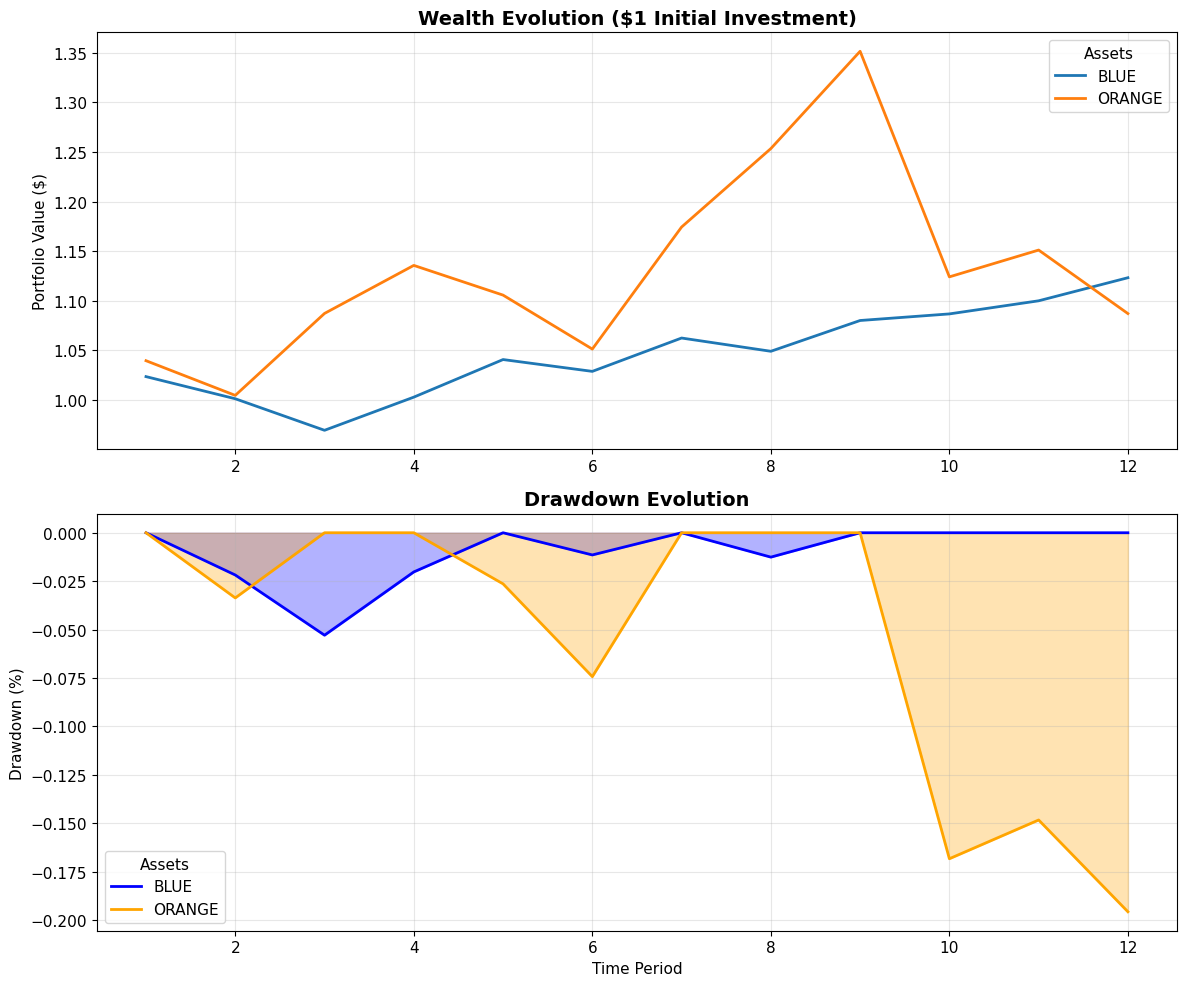

Observations:
• Wealth chart shows cumulative performance with reinvestment
• Drawdown chart highlights periods of decline from peaks
• Areas below zero represent losses from previous highs


In [578]:
# Plot wealth evolution and drawdowns
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# Wealth evolution
wealth.plot(ax=ax1, linewidth=2)
ax1.set_title('Wealth Evolution ($1 Initial Investment)', fontsize=14, fontweight='bold')
ax1.set_ylabel('Portfolio Value ($)')
ax1.legend(title='Assets')
ax1.grid(True, alpha=0.3)

# Drawdown plot
drawdown.plot(ax=ax2, linewidth=2, color=['blue', 'orange'])
ax2.fill_between(drawdown.index, 0, drawdown.iloc[:,0], alpha=0.3, color='blue')
ax2.fill_between(drawdown.index, 0, drawdown.iloc[:,1], alpha=0.3, color='orange')
ax2.set_title('Drawdown Evolution', fontsize=14, fontweight='bold')
ax2.set_ylabel('Drawdown (%)')
ax2.set_xlabel('Time Period')
ax2.legend(title='Assets')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Observations:")
print("• Wealth chart shows cumulative performance with reinvestment")
print("• Drawdown chart highlights periods of decline from peaks")
print("• Areas below zero represent losses from previous highs")

## 5. Performance Summary Table

Let's consolidate all key metrics into a single comparison table:

In [579]:
# Comprehensive performance metrics table
periods_per_year = 12  # Adjust for your data frequency

# Calculate all metrics
mean_return = returns.mean()
volatility = returns.std()
total_return = (returns + 1).prod(axis=0) - 1
annualized_return = (1 + mean_return)**periods_per_year - 1
annualized_volatility = volatility * np.sqrt(periods_per_year)
sharpe_ratio = (mean_return - rf) / volatility * np.sqrt(periods_per_year)
max_dd = drawdown.min()

# Create summary table
metrics_table = pd.DataFrame({
    'Mean Return': mean_return,
    'Volatility': volatility, 
    'Total Return': total_return,
    'Annualized Return': annualized_return,
    'Annualized Volatility': annualized_volatility,
    'Sharpe Ratio': sharpe_ratio,
    'Max Drawdown': max_dd
})

print("PERFORMANCE SUMMARY TABLE")
print("=" * 50)
print(metrics_table.round(4))

# Convert to percentages for better readability
print("\nSAME TABLE - PERCENTAGE FORMAT")
print("=" * 50)
metrics_pct = metrics_table.copy()
pct_columns = ['Mean Return', 'Volatility', 'Total Return', 'Annualized Return', 
               'Annualized Volatility', 'Max Drawdown']
metrics_pct[pct_columns] = metrics_pct[pct_columns] * 100
print(metrics_pct.round(2))

PERFORMANCE SUMMARY TABLE
        Mean Return  Volatility  Total Return  Annualized Return  \
BLUE           0.01      0.0240        0.1233             0.1268   
ORANGE         0.01      0.0796        0.0872             0.1268   

        Annualized Volatility  Sharpe Ratio  Max Drawdown  
BLUE                   0.0831        1.4447       -0.0529  
ORANGE                 0.2757        0.4352       -0.1956  

SAME TABLE - PERCENTAGE FORMAT
        Mean Return  Volatility  Total Return  Annualized Return  \
BLUE            1.0        2.40         12.33              12.68   
ORANGE          1.0        7.96          8.72              12.68   

        Annualized Volatility  Sharpe Ratio  Max Drawdown  
BLUE                     8.31          1.44         -5.29  
ORANGE                  27.57          0.44        -19.56  


## 6. Key Insights - "So What?"

Based on our analysis, here are the critical takeaways:

• **Same average, different risk**: Both assets have identical mean returns (~1% per period), but ORANGE exhibits 3x higher volatility than BLUE, demonstrating why mean return alone is insufficient for investment decisions.

• **Risk-adjusted performance favors stability**: BLUE's Sharpe ratio significantly exceeds ORANGE's due to lower volatility, making it more attractive on a risk-adjusted basis despite identical average returns.

• **Drawdown differences matter**: ORANGE experiences deeper drawdowns (larger maximum losses), requiring greater psychological tolerance and longer recovery periods for investors.

• **Compounding benefits consistency**: Lower volatility assets tend to achieve better long-term compounded returns due to reduced volatility drag, even with similar arithmetic mean returns.

• **Risk management implications**: Portfolios should consider volatility, drawdowns, and correlation patterns, not just expected returns, when making allocation decisions.

## 7. Using Your Own Data

### Step-by-Step Guide for Your CSV

1. **Prepare your CSV**: Ensure columns are asset prices with optional date column
2. **Set frequency**: Determine `periods_per_year` (252=daily, 12=monthly, 4=quarterly)  
3. **Run analysis**: Use the template below and modify the frequency parameter

```csv
Date,ASSET1,ASSET2,ASSET3
2023-01-01,100.50,50.25,75.80
2023-01-02,101.20,49.80,76.10
...
```

In [580]:
# Complete analysis template for your data
def analyze_returns_complete(filepath, periods_per_year=252, date_column=None, rf=0.0):
    """
    Complete return analysis for any CSV file
    
    Parameters:
    - filepath: path to your CSV file
    - periods_per_year: 252 (daily), 12 (monthly), 4 (quarterly)
    - date_column: name of date column (optional)
    - rf: risk-free rate (default 0.0)
    """
    # Load and process data
    data = pd.read_csv(filepath)
    if date_column and date_column in data.columns:
        data[date_column] = pd.to_datetime(data[date_column])
        data.set_index(date_column, inplace=True)
    
    # Calculate returns
    price_columns = data.select_dtypes(include=[np.number]).columns
    prices = data[price_columns] 
    returns = prices.pct_change().dropna()
    
    # Calculate all metrics
    wealth = (1 + returns).cumprod()
    rolling_peak = wealth.expanding().max()
    drawdown = (wealth - rolling_peak) / rolling_peak
    
    metrics = pd.DataFrame({
        'Mean Return': returns.mean(),
        'Volatility': returns.std(),
        'Total Return': (returns + 1).prod(axis=0) - 1,
        'Annualized Return': (1 + returns.mean())**periods_per_year - 1,
        'Annualized Volatility': returns.std() * np.sqrt(periods_per_year),
        'Sharpe Ratio': (returns.mean() - rf) / returns.std() * np.sqrt(periods_per_year),
        'Max Drawdown': drawdown.min()
    })
    
    return prices, returns, metrics

# Example usage:
# prices, returns, summary = analyze_returns_complete('your_data.csv', periods_per_year=12)
# print(summary.round(4))

print("Complete analysis function ready. Modify the example usage above with your file path.")

Complete analysis function ready. Modify the example usage above with your file path.


## 8. References

**Documentation & Technical Resources:**
- **[pandas]** pandas DataFrame.pct_change: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.pct_change.html - Official documentation for percentage change calculations
- **[Sharpe]** Sharpe, W.F. "The Sharpe Ratio": https://web.stanford.edu/~wfsharpe/art/sr/sr.htm - Original explanation by the Nobel laureate
- **[Investopedia]** Annualizing Returns: https://www.investopedia.com/terms/a/annualize.asp - Practical guide to return annualization

**Academic & Industry References:**
- **[CLM]** Campbell, J.Y., Lo, A.W., MacKinlay, A.C. "The Econometrics of Financial Markets": https://www.academia.edu/42883543/The_Econometrics_of_Financial_Markets - Comprehensive academic treatment of financial time series
- **[CFA 2024]** CFA Institute - Investment Returns Analysis: https://blogs.cfainstitute.org/investor/2024/05/07/investment-returns-are-not-random/ - Industry perspectives on return behavior
- **[Coursera]** Vaidyanathan V., Martellini L. "Introduction to Portfolio Construction and Analysis with Python" https://www.coursera.org/learn/introduction-portfolio-construction-python/home/module/1 - Returns with Python

**Data Conventions:**
- Trading day conventions vary by market but 252 days/year is the most common assumption for equity markets
- Risk-free rate proxies typically use government bond yields (e.g., 3-month Treasury bills)